In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re
import tensorflow as tf

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.activations import elu,relu,sigmoid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, LSTM, Embedding, Bidirectional

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [3]:
ds = pd.read_csv('IMDB_dataset.csv')

In [4]:
ds.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
ds.shape

(50000, 2)

In [6]:
ds.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
ds.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [8]:
duplicate_records = ds[ds.duplicated()].index
len(duplicate_records)

418

In [9]:
ds.iloc[3537]

review       Quite what the producers of this appalling ada...
sentiment                                             negative
Name: 3537, dtype: object

In [10]:
ds[ds['review'].str.contains('Quite what the producers of this appalling')]

,review,sentiment
2013,Quite what the producers of this appalling ada...,negative
3537,Quite what the producers of this appalling ada...,negative


In [11]:
ds.drop(duplicate_records, inplace=True)

In [12]:
ds.shape

(49582, 2)

In [13]:
ds.review.iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Data cleaning and Data Preprocessing

In [15]:
### Customizing stop words as per the data

stop_words = stopwords.words('english')
new_stopwords = ['movie','one','shall','could','would','film','might'] ## adding new words to stopwords list
stop_words.extend(new_stopwords)
stop_words.remove('not') ## removing not from the stopwords list
stop_words= set(stop_words)

In [16]:
#stop_words
#stopwords.words('english')

In [17]:
## Data Cleaning and Preprocessing

def remove_special_char(content):
    content = re.sub(r'<.*?>',' ',content)
    content = re.sub('\[[^!@#$%&]*\]',' ',content)
    return content

def remove_other_char(content):
    content = re.sub('[^a-zA-Z0-9]',' ',content)
    return content

def remove_url(content):
    return re.sub(r'http:\S+',' ',content)

def remove_stopwords(content):
    clean_data = []
    for i in content.split():
        if i.strip().lower() not in stop_words:
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

def apply_stemming(content):
    stemming = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    clean_data = []
    for i in content.split():
        clean_data.append(lemmatizer.lemmatize(i.strip().lower()))
    return " ".join(clean_data)

def word_expansion(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "cannot", content)
    content = re.sub(r"don\'t", "do not",content)
    content = re.sub(r"shouldn\'t", "should not",content)
    content = re.sub(r"needn\'t", "need not",content)
    content = re.sub(r"hasn\'t", "has not",content)
    content = re.sub(r"haven\'t", "have not",content)
    content = re.sub(r"weren\'t", "were not",content)
    content = re.sub(r"mightn\'t", "might not",content)
    content = re.sub(r"didn\'t", "did not",content)
    content = re.sub(r"n\'t", "not",content)
    content = re.sub(r"\'re", "are",content)
    content = re.sub(r"\'s", "is",content)
    content = re.sub(r"\'ll", "will",content)
    content = re.sub(r"\'ve", "have",content)
    content = re.sub(r"\'m", "am",content)
    return content

def data_cleaning(content):
    content = remove_special_char(content)
    content = remove_url(content)
    #content = word_expansion(content)
    content = remove_other_char(content)
    content = remove_stopwords(content)
    content = apply_stemming(content)
    return content

In [18]:
ds['review'] = ds['review'].apply(data_cleaning)

In [19]:
ds.review.iloc[0]

'reviewer mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching 

In [20]:
ds.review.describe()

count                                                 49582
unique                                                49574
top       not biggest fan western two personal favorite ...
freq                                                      2
Name: review, dtype: object

In [21]:
ds.sentiment.describe()

count        49582
unique           2
top       positive
freq         24884
Name: sentiment, dtype: object

In [22]:
ds.sentiment.value_counts() ### Perfectly balanced dataset

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [23]:
print("Unique reviews :",ds.review.nunique())

Unique reviews : 49574


## Exploratory Data Analysis

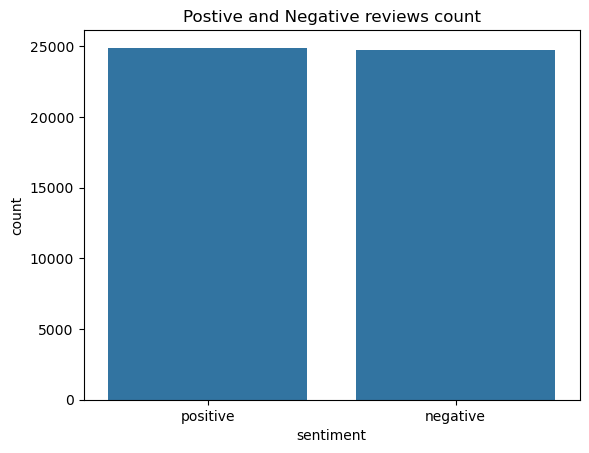

In [25]:
## Dataset is perfectly balanced for classification
sns.countplot(x = ds['sentiment'])
plt.title('Postive and Negative reviews count')
plt.show()

(-0.5, 1499.5, 799.5, -0.5)

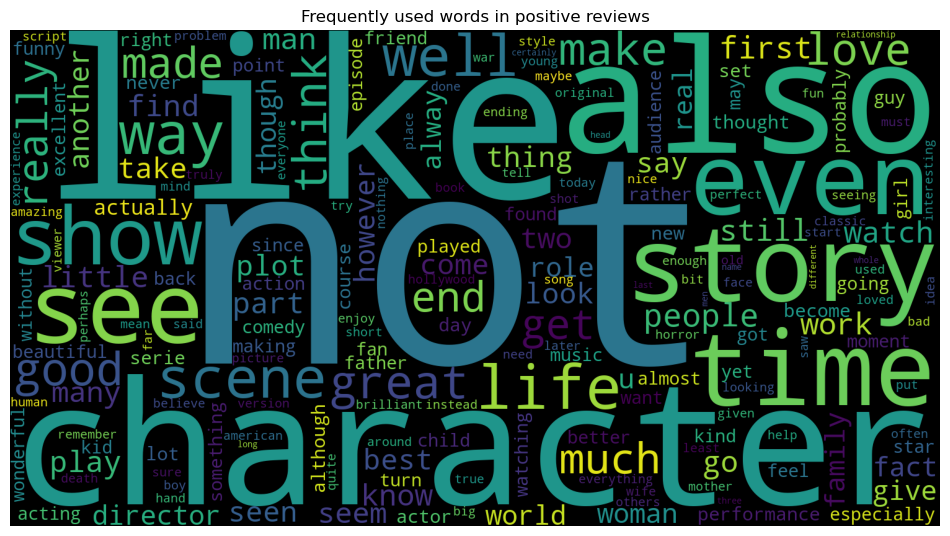

In [26]:
sent = ds['review']
positive = ' '.join(map(str, sent[ds['sentiment'] == 'positive']))
negative = ' '.join(map(str, sent[ds['sentiment'] == 'negative']))

positive_wordcloud = WordCloud(width = 1500, height = 800, stopwords=stop_words, min_font_size=12, background_color='black').generate(positive)
plt.figure(figsize=(12,10))
plt.title('Frequently used words in positive reviews')
plt.imshow(positive_wordcloud)
plt.axis('off')

(-0.5, 1499.5, 799.5, -0.5)

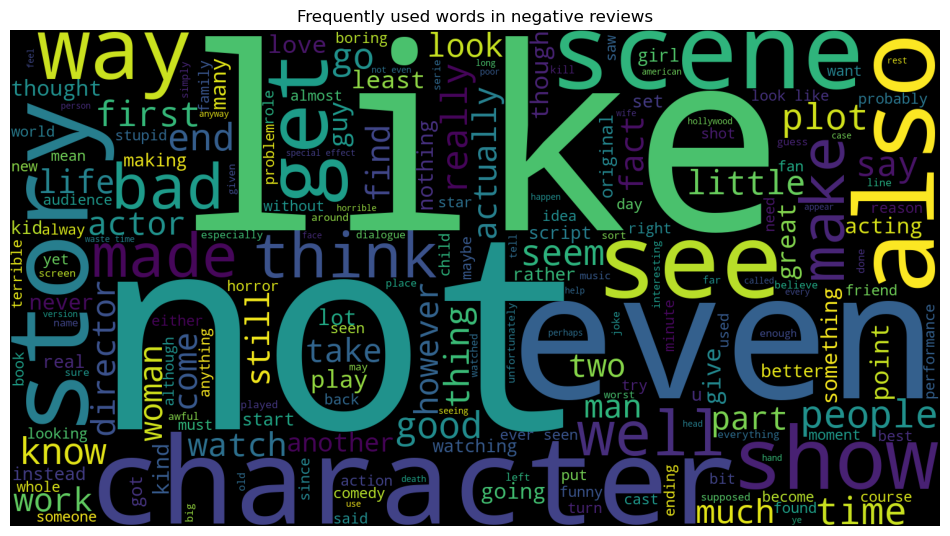

In [27]:
negative_wordcloud = WordCloud(width = 1500, height = 800, stopwords=stop_words, min_font_size=12, background_color='black').generate(negative)
plt.figure(figsize=(12,10))
plt.title('Frequently used words in negative reviews')
plt.imshow(negative_wordcloud)
plt.axis('off')

Text(0.5, 1.0, 'Negative Reviews')

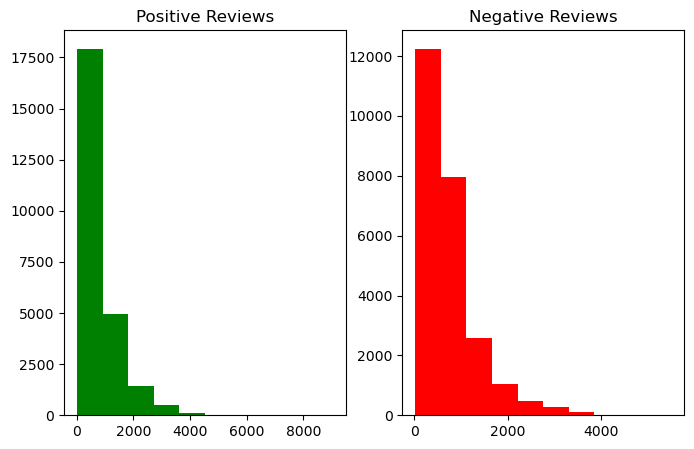

In [28]:
##Visualizing the length of reviews
figure,(pos_ax,neg_ax) = plt.subplots(1,2,figsize=(8,5))
length_positive_review = ds[ds['sentiment'] == 'positive']['review'].str.len()
pos_ax.hist(length_positive_review, color='green')
pos_ax.set_title("Positive Reviews")

length_negative_review = ds[ds['sentiment'] == 'negative']['review'].str.len()
neg_ax.hist(length_negative_review, color='red')
neg_ax.set_title("Negative Reviews")

Text(0.5, 1.0, 'Positive Reviews')

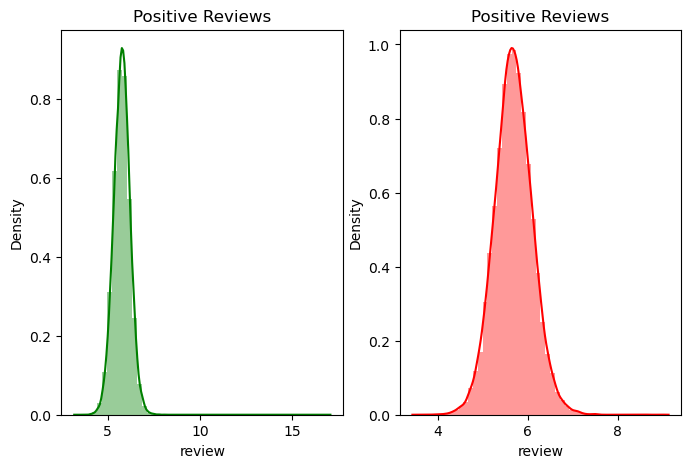

In [29]:
## Average length of the words used in the review
figure,(pos_ax,neg_ax) = plt.subplots(1,2,figsize=(8,5))
positive_words = ds[ds['sentiment'] == 'positive']['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(positive_words.map(lambda x: np.mean(x)),ax = pos_ax, color='green')
pos_ax.set_title("Positive Reviews")

negative_words = ds[ds['sentiment'] == 'negative']['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(negative_words.map(lambda x: np.mean(x)),ax = neg_ax, color='red')
neg_ax.set_title("Positive Reviews")

In [30]:
## Top n words used in the reviews using count vectorizer and ngrams

def get_top_ngrams_words(corpus, n, g):
    vec =  CountVectorizer(ngram_range=(g,g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x : x[1], reverse=True)
    return words_freq[:n]

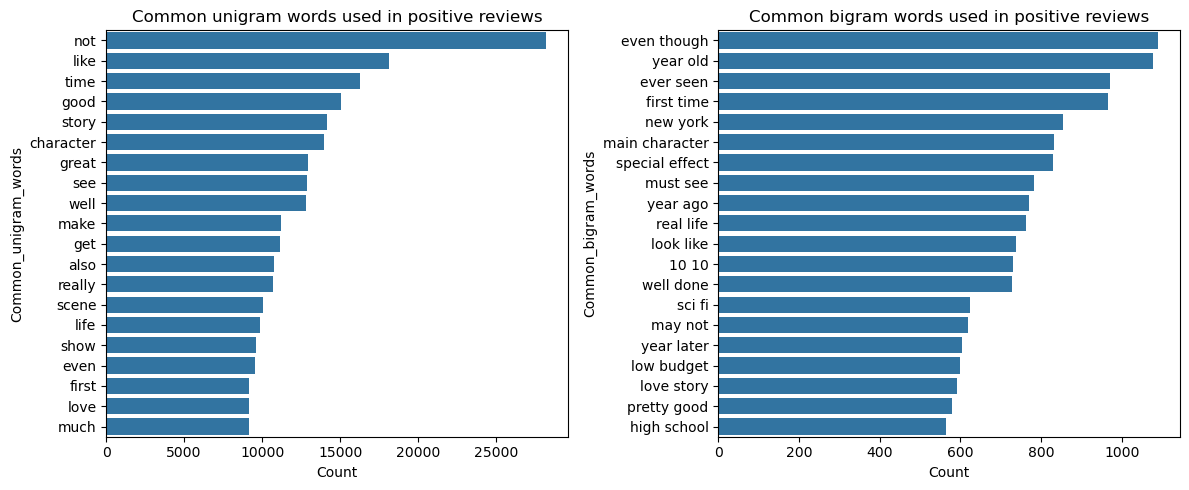

In [31]:
top_used_positive_unigrams = get_top_ngrams_words(ds[ds.sentiment == "positive"]['review'],20,1)
top_used_positive_unigrams = dict(top_used_positive_unigrams)
temp_df_uni = pd.DataFrame(columns = ['Common_unigram_words', 'Count'])
temp_df_uni['Common_unigram_words'] = list(top_used_positive_unigrams.keys())
temp_df_uni['Count'] = list(top_used_positive_unigrams.values())

top_used_positive_bigrams = get_top_ngrams_words(ds[ds.sentiment == "positive"]['review'],20,2)
top_used_positive_bigrams = dict(top_used_positive_bigrams)
temp_df_bi = pd.DataFrame(columns = ['Common_bigram_words', 'Count'])
temp_df_bi['Common_bigram_words'] = list(top_used_positive_bigrams.keys())
temp_df_bi['Count'] = list(top_used_positive_bigrams.values())

figure,(posuni_ax,posbi_ax) = plt.subplots(1,2,figsize=(12,5))
posuni_ax.set_title('Common unigram words used in positive reviews')
sns.barplot(y=temp_df_uni['Common_unigram_words'], x=temp_df_uni['Count'], ax=posuni_ax)

posbi_ax.set_title('Common bigram words used in positive reviews')
sns.barplot(y=temp_df_bi['Common_bigram_words'], x=temp_df_bi['Count'], ax=posbi_ax)
plt.tight_layout()
plt.show()

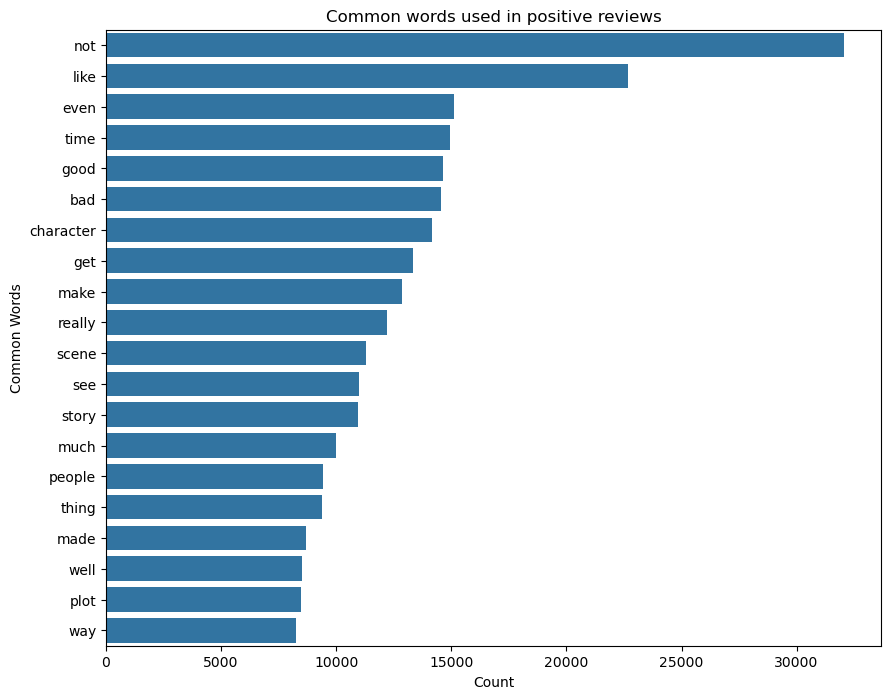

In [32]:
top_used_negative_unigrams = get_top_ngrams_words(ds[ds.sentiment == "negative"]['review'],20,1)
top_used_negative_unigrams = dict(top_used_negative_unigrams)
temp_df = pd.DataFrame(columns = ['Common Words', 'Count'])
temp_df['Common Words'] = list(top_used_negative_unigrams.keys())
temp_df['Count'] = list(top_used_negative_unigrams.values())
plt.figure(figsize = (10,8))
plt.title('Common words used in positive reviews')
sns.barplot(y=temp_df['Common Words'], x=temp_df['Count'])
plt.show()

In [33]:
corpus = []
for i in ds['review']:
    words = [word.lower() for word in word_tokenize(i)]
    corpus.append(words)
num_words = len(corpus)
num_words

49582

## Train test Split

In [35]:
ds['sentiment'] = ds['sentiment'].apply(lambda x:1 if x == 'positive' else 0)

In [36]:
x = ds['review']
y = ds['sentiment']
print(x.shape, y.shape)

(49582,) (49582,)


In [37]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.20, random_state=42)
print(x_train.shape, x_test.shape)

(39665,) (9917,)


In [38]:
x_train[0]

'reviewer mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching 

## Word Embedding using TFIDF

### Unigram

In [41]:
tfidf_unigram = TfidfVectorizer(ngram_range=(1,3), max_features=3000)

In [42]:
x_train_uni_tfidf = tfidf_unigram.fit_transform(x_train).toarray()
x_test_uni_tfidf = tfidf_unigram.transform(x_test).toarray()
print(x_train_uni_tfidf.shape, x_test_uni_tfidf.shape)

(39665, 3000) (9917, 3000)


In [43]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(x_train_uni_tfidf, y_train)
train_pred = lr.predict(x_train_uni_tfidf)
y_pred = lr.predict(x_test_uni_tfidf)
print(accuracy_score(y_pred,y_test))
print(accuracy_score(train_pred,y_train))

0.8852475547040436
0.907172570276062


In [44]:
predictions = lr.predict_proba(x_test_uni_tfidf)[:,1]
predictions[3]

0.06805651604682499

In [45]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train_uni_tfidf, y_train)
y_pred = mnb.predict(x_test_uni_tfidf)
print(accuracy_score(y_pred,y_test))

0.8517696884138348


In [46]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(x_train_uni_tfidf, y_train)
y_pred = svc.predict(x_test_uni_tfidf)
print(accuracy_score(y_pred,y_test))

0.8800040334778663


## Prediction

In [48]:
test_df = pd.read_excel('IMDB_test.xlsx')
test_df.head()

,review
0,"""the movie is good"""
1,"""the movie is bad"""
2,"""the move is a flop"""
3,"""the movie is horrible"""
4,"""the movie is great"""


In [49]:
test_df['processed_text'] = test_df['review'].apply(data_cleaning)
test_df.head(10)

,review,processed_text
0,"""the movie is good""",good
1,"""the movie is bad""",bad
2,"""the move is a flop""",move flop
3,"""the movie is horrible""",horrible
4,"""the movie is great""",great
5,"Probably my all-time favorite movie, a story o...",probably time favorite story selflessness sacr...
6,I sure would like to see a resurrection of a u...,sure like see resurrection dated seahunt serie...
7,"This show was an amazing, fresh & innovative i...",show amazing fresh innovative idea 70 first ai...
8,Encouraged by the positive comments about this...,encouraged positive comment looking forward wa...
9,If you like original gut wrenching laughter yo...,like original gut wrenching laughter like youn...


In [50]:
vector = tfidf_unigram.transform(test_df['processed_text']).toarray()
vector[5].shape

(3000,)

In [51]:
test_df['sentiment'] = lr.predict(vector)
for i in range(len(test_df['sentiment'])):
    if test_df['sentiment'].iloc[i] == 1:
        test_df['sentiment'].iloc[i] = "Positive"
    else:
        test_df['sentiment'].iloc[i] = "Negative"
test_df.head()

,review,processed_text,sentiment
0,"""the movie is good""",good,Positive
1,"""the movie is bad""",bad,Negative
2,"""the move is a flop""",move flop,Positive
3,"""the movie is horrible""",horrible,Negative
4,"""the movie is great""",great,Positive


In [52]:
import pickle
pickle.dump(tfidf_unigram, open("best_vectorizer.pkl",'wb'))
pickle.dump(lr,open("best_model.pkl",'wb'))

### Bigram

### Trigram

## Word embedding using Word2Vec

In [56]:
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess
import gensim

In [57]:
ds['review'].iloc[0]

'reviewer mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching 

In [58]:
words = []
for i in ds['review']:
    sent = sent_tokenize(i) #converts corpus into sentence/document
    for j in sent:
        if j not in words:
            words.append(simple_preprocess(j)) #Converts each document into words in lower case

In [59]:
len(words)

49582

In [60]:
print(len(words[0]), len(words[1]))

163 87


In [61]:
own_model = gensim.models.Word2Vec(words, vector_size=100, window=5, min_count=5)

In [62]:
own_model.corpus_count

49582

In [63]:
own_model.wv['good']

array([-0.14413138,  0.2571407 ,  1.4376384 ,  0.05983413,  1.9804639 ,
        1.9028763 ,  1.0224949 ,  1.9624186 ,  0.29436776, -2.438827  ,
        0.41995832, -0.66922706,  0.6798404 , -0.5048228 , -0.64626926,
        1.4446604 ,  3.3185124 , -1.301509  ,  0.9324999 ,  1.7916117 ,
        1.7606428 ,  0.593802  ,  1.0640371 ,  0.54889375, -1.9803163 ,
       -1.2036264 , -0.33398852, -0.9848812 ,  1.2515923 , -0.6658853 ,
        0.33017838, -1.1123154 , -1.4617671 , -0.29820904, -0.00498235,
        0.64246607,  2.3905246 , -0.737017  , -2.5356421 ,  2.960796  ,
       -0.5255626 , -0.04180546,  1.0700401 , -0.16999087, -1.2082641 ,
        0.6206076 , -2.0518897 , -0.6110868 ,  0.23923105,  1.3266734 ,
       -1.1669159 , -0.65951544, -0.36046723, -2.0638206 ,  1.3595113 ,
       -0.5412819 , -0.35545456,  1.0896459 ,  0.16784105, -0.53928035,
       -0.82637584,  0.69515616,  0.6779908 ,  0.4650117 ,  1.5579439 ,
       -0.9542624 , -0.94239587, -0.30956653,  0.3481019 , -0.23

In [64]:
own_model.wv.similarity('good','better')

0.44799095

In [65]:
own_model.wv.most_similar('oz')

[('wizard', 0.7900253534317017),
 ('python', 0.630902111530304),
 ('darkwing', 0.605504035949707),
 ('monty', 0.5888091325759888),
 ('saddle', 0.5687064528465271),
 ('canceling', 0.565971851348877),
 ('velvet', 0.5609833002090454),
 ('emcee', 0.5582671761512756),
 ('hosted', 0.5553146004676819),
 ('broadcasting', 0.53934246301651)]

In [ ]:
def avgWord2Vec(doc):
    return np.mean([own_model.wv[word] for word in doc if word in own_model.wv.index_to_key]
                or [np.zeros(100)], axis=0)

In [ ]:
from tqdm import tqdm
X = []
for i in tqdm(range(len(words))):
    #print(words[i])
    X.append(avgWord2Vec(words[i]))

In [68]:
x_word2vec = np.array(X)
x_word2vec = np.stack(X, axis=0)

x_word2vec.shape

(49582, 100)

In [69]:
x_train_word2vec,x_test_word2vec,y_train,y_test = train_test_split(x_word2vec,y, test_size=0.20, random_state=42)

print(x_train_word2vec.shape)
print(x_test_word2vec.shape)

(39665, 100)
(9917, 100)


In [75]:
classifier = Sequential()

#Adding input layer
classifier.add(Dense(units=1, activation=relu))

#Adding hidden layer 1
classifier.add(Dense(units=10, activation=relu))

#Adding hidden layer 2
classifier.add(Dense(units=9, activation=relu))
classifier.add(Dropout(0.2)) #makes 20% neurons as dead neurons

#Adding output layer
classifier.add(Dense(units=1, activation=sigmoid))

classifier.compile(optimizer='adam',metrics = ['accuracy'], loss='binary_crossentropy')

#Without early stopping
#model = classifier.fit(x_train,y_train,validation_split=0.30,epochs=100)

early_stopping = EarlyStopping(monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

#With early stopping
model = classifier.fit(x_train_word2vec,y_train,validation_split=0.20,batch_size=10,epochs=20, callbacks=early_stopping)

Epoch 1/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7595 - loss: 0.5091 - val_accuracy: 0.8515 - val_loss: 0.3472
Epoch 2/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8507 - loss: 0.3673 - val_accuracy: 0.8550 - val_loss: 0.3393
Epoch 3/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8546 - loss: 0.3501 - val_accuracy: 0.8579 - val_loss: 0.3363
Epoch 4/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8607 - loss: 0.3416 - val_accuracy: 0.8569 - val_loss: 0.3322
Epoch 5/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8570 - loss: 0.3461 - val_accuracy: 0.8607 - val_loss: 0.3308
Epoch 6/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8595 - loss: 0.3392 - val_accuracy: 0.8545 - val_loss: 0.3423
Epoch 7/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8635 - loss: 0.3389 - val_accuracy: 0.8605 - val_loss: 0.3273
Epoch 8/20
3174/3174 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8602 - loss: 0.3408 - 

In [80]:
y_pred = classifier.predict(x_test_word2vec)
y_pred = y_pred >= 0.5

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [78]:
cm = confusion_matrix(y_test,y_pred)
score = accuracy_score(y_test,y_pred)
cm,score

(array([[4368,  571],
        [ 838, 4140]], dtype=int64),
 0.8579207421599274)

In [79]:
lr = LogisticRegression()
lr.fit(x_train_word2vec, y_train)
train_pred = lr.predict(x_train_word2vec)
y_pred = lr.predict(x_test_word2vec)
print(accuracy_score(y_pred,y_test))
print(accuracy_score(train_pred,y_train))

0.8633659372794191
0.8659019286524644


## Word Embedding using LSTM

In [90]:
vocab_size = 5000

onehot_repr = [one_hot(input_text=words,n=vocab_size) for words in ds['review']]
#onehot_repr[0]

In [85]:
sent_length = 150
embedded_docs = pad_sequences(sequences=onehot_repr, padding='pre',maxlen = sent_length)
len(embedded_docs[0])

150

In [86]:
### Creating Embedding and LSTM model
dimension = 300
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=dimension, input_length=sent_length))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
x_lstm = np.array(embedded_docs)
x_lstm.shape

(49582, 150)

In [88]:
x_train_lstm,x_test_lstm,y_train,y_test = train_test_split(x_lstm,y, test_size=0.20, random_state=0)
print(x_train_lstm.shape)
print(x_test_lstm.shape)

(39665, 150)
(9917, 150)


In [89]:
lstm_model.fit(x_train_lstm,y_train, epochs=2, batch_size=64, validation_data=(x_test_lstm,y_test))

Epoch 1/2
620/620 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - accuracy: 0.7734 - loss: 0.4572 - val_accuracy: 0.8638 - val_loss: 0.3250
Epoch 2/2
620/620 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.8981 - loss: 0.2539 - val_accuracy: 0.8641 - val_loss: 0.3371
